In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
from glob import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import easysnowdata
import pandas as pd
#from geogif import gif

/mnt/Backups/gbrench/sw/miniconda3/envs/easysnowdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def gh_to_xarray(gh_dir, bbox, epsg=4326, interpolate_na=False):
    
    dirs = os.listdir(gh_dir)
    datasets = []
    acquisition_list = []
    
    for idir in dirs:
        tif_path = glob(f'{gh_dir}/{idir}/*.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        date = datetime.strptime(tif_fn[0:8], '%Y%m%d')
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"time": date})
        src = src.expand_dims("time")
        
        src = src.rename({'band1':'snow_depth'})
        src = src.rio.write_crs(epsg)
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)

        src = src.rio.clip_box(bbox[0], bbox[1], bbox[2], bbox[3])
        
        datasets.append(src)
        #print(src[file_type].shape, src.dates.item())
       
    ds = xr.concat(datasets, dim="time", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('time')

    return ds 

In [3]:
data_path = '../../data/merced_application'

In [4]:
sd_ds = gh_to_xarray(data_path, bbox=[-119.74, 37.55, -119.21, 37.94])


KeyboardInterrupt



In [5]:
StationCollection = easysnowdata.automatic_weather_stations.StationCollection()

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


In [6]:
StationCollection.all_stations.astype(dict(beginDate=str, endDate=str)).explore(
    column="network", cmap="bwr"
)

In [8]:
OstranderCCSS = easysnowdata.automatic_weather_stations.StationCollection()
OstranderCCSS.get_data("STR")
#Ostrander_ds = sd_ds.sel(x=OstranderCCSS.stations.longitude.item(), y=OstranderCCSS.stations.latitude.item(), method='nearest')

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.


In [26]:
df = OstranderCCSS.data.copy()
df['water_year'] = df.index.to_series().apply(lambda d: d.year if d.month < 10 else d.year + 1)

# Step 2: Find the peak WTEQ per water year
peak_wteq = df.groupby('water_year')['WTEQ'].max()

# Step 3: Compute mean peak WTEQ
mean_peak = peak_wteq.mean()

# Step 4: Compute anomaly percent
anomaly_percent = 100 * (peak_wteq - mean_peak) / mean_peak

# Combine into a DataFrame for presentation
summary = pd.DataFrame({
    'peak_WTEQ': peak_wteq,
    'anomaly_percent': anomaly_percent
})

summary.anomaly_percent.abs().mean()

np.float64(42.26378367538028)

In [17]:
OstranderCCSS_2016 = OstranderCCSS.data.where(OstranderCCSS.data.index.dt.year == 2016)

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

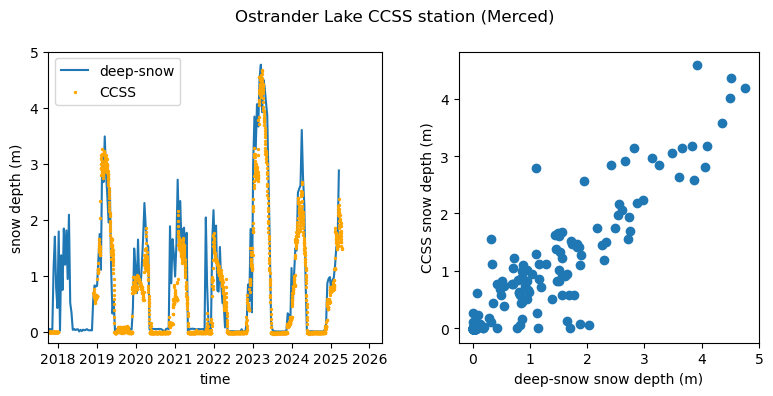

In [87]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
Ostrander_ds.snow_depth.plot(ax=ax[0], label='deep-snow')
ax[0].scatter(OstranderCCSS.data.index, OstranderCCSS.data.SNWD, label='CCSS', s=2, c='orange', zorder=2)
ax[0].set_xlim(pd.to_datetime('20171001'))
ax[0].set_ylim(-0.2, 5)
ax[0].legend()
ax[0].set_title('')
ax[0].set_ylabel('snow depth (m)')

valid_times = OstranderCCSS.data.SNWD.dropna().index
common_times = valid_times.intersection(Ostrander_ds.time.to_index())

ax[1].scatter(Ostrander_ds.snow_depth.sel(time=common_times), OstranderCCSS.data.SNWD.loc[common_times])
ax[1].set_aspect('equal')
ax[1].set_xlabel('deep-snow snow depth (m)')
ax[1].set_ylabel('CCSS snow depth (m)')

f.suptitle('Ostrander Lake CCSS station (Merced)')
f.tight_layout()

In [36]:
TenayaCCSS = easysnowdata.automatic_weather_stations.StationCollection()
TenayaCCSS.get_data("TNY")
Tenaya_ds = sd_ds.sel(x=TenayaCCSS.stations.longitude.item(), y=TenayaCCSS.stations.latitude.item(), method='nearest')

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.


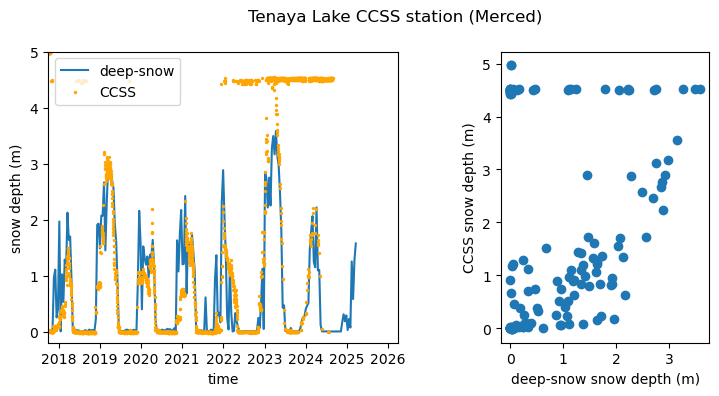

In [86]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
Tenaya_ds.snow_depth.plot(ax=ax[0], label='deep-snow')
ax[0].scatter(TenayaCCSS.data.index, TenayaCCSS.data.SNWD, label='CCSS', s=2, c='orange', zorder=2)
ax[0].set_xlim(pd.to_datetime('20171001'))
ax[0].set_ylim(-0.2, 5)
ax[0].legend()
ax[0].set_title('')
ax[0].set_ylabel('snow depth (m)')

valid_times = TenayaCCSS.data.SNWD.dropna().index
common_times = valid_times.intersection(Tenaya_ds.time.to_index())

ax[1].scatter(Tenaya_ds.snow_depth.sel(time=common_times), TenayaCCSS.data.SNWD.loc[common_times])
ax[1].set_aspect('equal')
ax[1].set_xlabel('deep-snow snow depth (m)')
ax[1].set_ylabel('CCSS snow depth (m)')

f.suptitle('Tenaya Lake CCSS station (Merced)')
f.tight_layout()

In [40]:
WhitewolfCCSS = easysnowdata.automatic_weather_stations.StationCollection()
WhitewolfCCSS.get_data("WHW")
Whitewolf_ds = sd_ds.sel(x=WhitewolfCCSS.stations.longitude.item(), y=WhitewolfCCSS.stations.latitude.item(), method='nearest')

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.


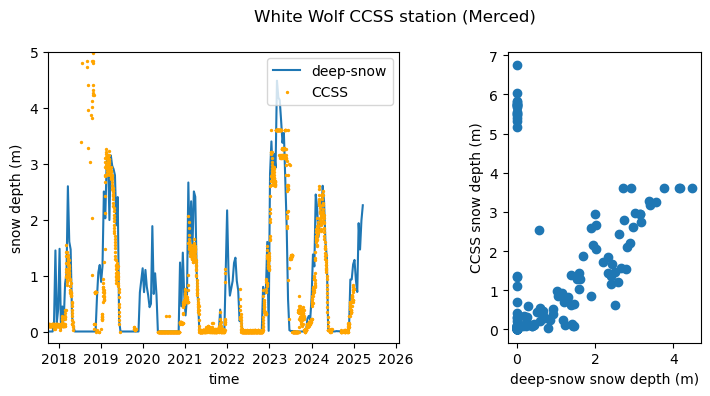

In [85]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
Whitewolf_ds.snow_depth.plot(ax=ax[0], label='deep-snow')
ax[0].scatter(WhitewolfCCSS.data.index, WhitewolfCCSS.data.SNWD, label='CCSS', s=2, c='orange', zorder=2)
ax[0].set_xlim(pd.to_datetime('20171001'))
ax[0].set_ylim(-0.2, 5)
ax[0].legend()
ax[0].set_title('')
ax[0].set_ylabel('snow depth (m)')

valid_times = WhitewolfCCSS.data.SNWD.dropna().index
common_times = valid_times.intersection(Whitewolf_ds.time.to_index())

ax[1].scatter(Whitewolf_ds.snow_depth.sel(time=common_times), WhitewolfCCSS.data.SNWD.loc[common_times])
ax[1].set_aspect('equal')
ax[1].set_xlabel('deep-snow snow depth (m)')
ax[1].set_ylabel('CCSS snow depth (m)')

f.suptitle('White Wolf CCSS station (Merced)')
f.tight_layout()

In [45]:
TuolumneCCSS = easysnowdata.automatic_weather_stations.StationCollection()
TuolumneCCSS.get_data("TUM")
Tuolumne_ds = sd_ds.sel(x=TuolumneCCSS.stations.longitude.item(), y=TuolumneCCSS.stations.latitude.item(), method='nearest')

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.


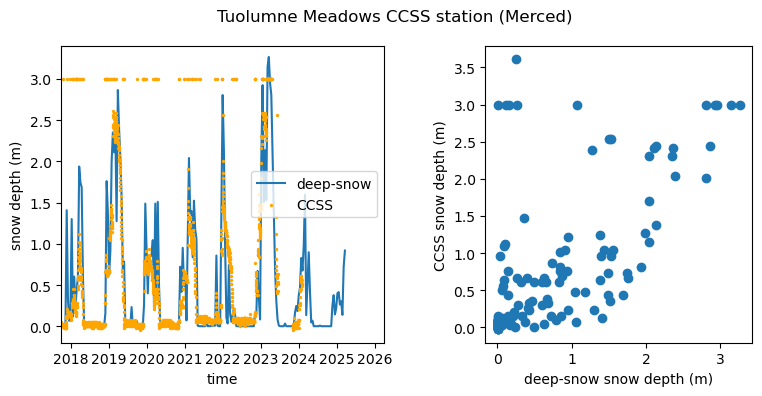

In [89]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
Tuolumne_ds.snow_depth.plot(ax=ax[0], label='deep-snow')
ax[0].scatter(TuolumneCCSS.data.index, TuolumneCCSS.data.SNWD, label='CCSS', s=2, c='orange', zorder=2)
ax[0].set_xlim(pd.to_datetime('20171001'))
ax[0].set_ylim(-0.2, 3.4)
ax[0].legend()
ax[0].set_title('')
ax[0].set_ylabel('snow depth (m)')

valid_times = TuolumneCCSS.data.SNWD.dropna().index
common_times = valid_times.intersection(Tuolumne_ds.time.to_index())

ax[1].scatter(Tuolumne_ds.snow_depth.sel(time=common_times), TuolumneCCSS.data.SNWD.loc[common_times])
ax[1].set_aspect('equal')
ax[1].set_xlabel('deep-snow snow depth (m)')
ax[1].set_ylabel('CCSS snow depth (m)')

f.suptitle('Tuolumne Meadows CCSS station (Merced)')
f.tight_layout()

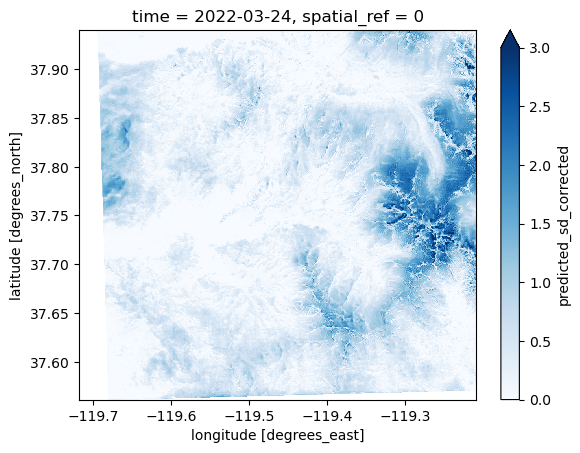

In [119]:
sd_ds.isel(time=136).snow_depth.plot.imshow(cmap='Blues', vmin=0, vmax=3)

In [124]:
#gif(sd_ds.snow_depth, cmap='Blues', fps=2)

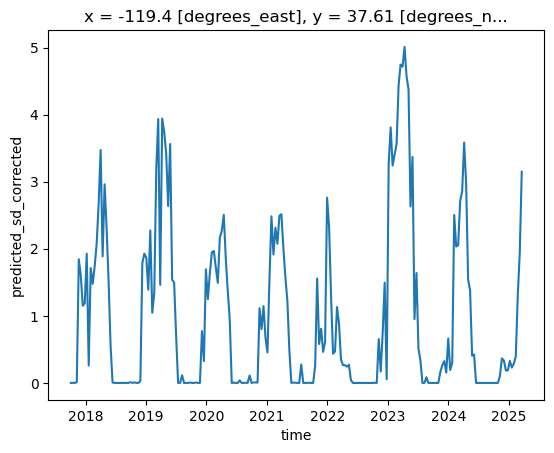

In [7]:
sd_ds.snow_depth.isel(x=600, y=650).plot()

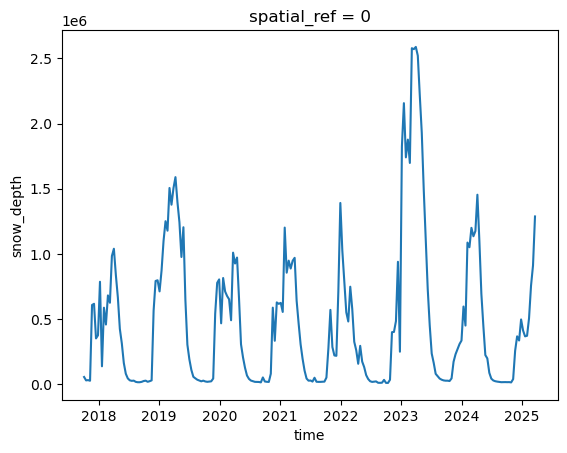

In [8]:
sd_ds.snow_depth.sum(dim=['x', 'y']).plot()